<a href="https://colab.research.google.com/github/frfusch21/DTS_GGU_5/blob/Hartantya-AT/quito_city_cab_ride_duration_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Get Data**

In [41]:
!pip install bayesian-optimization

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [42]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [43]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import xgboost as xgb

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.linear_model import LinearRegression, Ridge, BayesianRidge, ElasticNet, Lasso

from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
from sklearn.preprocessing import StandardScaler
from bayes_opt import BayesianOptimization

%matplotlib inline
plt.rcParams['figure.figsize'] = [16, 10]

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

#import os
#print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

# <h1> Read Data </h1>

In [44]:
#uio = pd.read_csv('/content/drive/MyDrive/Belajar/all-data_clean.csv', header=0, sep=',', encoding="Latin1")
uio = pd.read_csv('/content/drive/MyDrive/Belajar/uio_clean.csv', header=0, sep=',', encoding="Latin1")
uio.head()

FileNotFoundError: ignored

Out of all the 4 datasets the data in file uio_clean.csv is for the Quito city. The data also has date-time information for pickup and drop off. These need to be converted to python date time format

In [ ]:
uio['pickup_datetime'] = pd.to_datetime(uio['pickup_datetime'], format='%Y/%m/%d %H:%M:%S')
uio['dropoff_datetime'] = pd.to_datetime(uio['dropoff_datetime'], format='%Y-%m-%d %H:%M:%S')

#checked a sample of file in notepad also to verify the datetime format. 

In [ ]:
print(uio['pickup_datetime'].dt.time.max()) #There seems to be some data issue with this file as the pickup times are only between 01:00:01hours and 12:59:59 hours
print(uio['pickup_datetime'].dt.time.min())

In [ ]:
uio.info()
#The datetime values are successfully converted

In [ ]:
uio.describe()

**Observations from the above table:**
* no. of records = 32,366
* ID column is unique identified for each trip - this will not add any value with respect to the modeling work. So, it will need to be dropped.
* Columns that have outliers - pickup_latitude, drop_off_latitude, trip_duration, dist_meters, wait_sec. Their max values are unreasonably high eg. trip duration max value is ~596,523 hours, which cannot be true for any trip. These will require treatment.
* Minimum trip duration is negative, which is not possible in reality
* Minimum dist_meters is ~1.1m, which again is not any meaningful trip

**Initial Data Exploration**

In [ ]:
uio['vendor_id'].unique()

In [ ]:
uio['store_and_fwd_flag'].unique() #store and forward flag has only one value - so it's not useful for modeling purpose

In [ ]:
np.percentile(uio['trip_duration'], np.arange(0,101))

In [ ]:
np.percentile(uio['pickup_latitude'], np.arange(0,101))

In [ ]:
#uio = uio[(uio['dropoff_latitude'] >= -0.32628809) & (uio['dropoff_latitude'] <= -0.07806344)]   #remove the outliers from dropoff latitude
#uio.shape

In [ ]:
#uio = uio[(uio['pickup_latitude'] >= -0.32628809) & (uio['pickup_latitude'] <= -0.07806344)]   #remove the outliers from pickup latitude
#uio.shape


In [ ]:
np.percentile(uio['dist_meters']/1000, np.arange(90,101)) #percentile distribution of trip distance in km. Based on this the upper limit
#for ditastance is chosen as  50km

In [ ]:
uio['dist_meters'] = uio['dist_meters']/1000
uio = uio[uio['dist_meters'] <= 50]  
uio.shape

In [ ]:
np.percentile(uio['trip_duration']/60, np.arange(0,101))

In [ ]:
uio['trip_duration'] =  uio['trip_duration']/60
uio.shape

In [ ]:
uio = uio[(uio['trip_duration'] >= 0.5) & (uio['trip_duration'] <=350. )] #trip duration must be between 1 min and 350 minutes
uio.shape

In [ ]:
np.percentile(uio['trip_duration'], np.arange(0,101))   #veriy the values of trip duration in minutes

In [ ]:
uio['wait_sec'] = uio['wait_sec']/60
np.percentile(uio['wait_sec'], np.arange(0,101))  #distrubution of waiting time in minutes. 
#Based on this we will drop any records with more than 100 munutes of waiting tmie

In [ ]:
uio = uio[uio['wait_sec'] <= 100]
uio.shape

In [ ]:
uio[uio['trip_duration'] <= uio['wait_sec']].count() #Trip duration should not be less than waiting time

In [ ]:
uio =uio[uio['trip_duration'] > uio['wait_sec']]
uio.shape

In [ ]:
uio[uio['trip_duration'] <= uio['wait_sec']].count()

In [ ]:
np.percentile(uio['trip_duration']- (uio['dropoff_datetime'] - uio['pickup_datetime']).dt.seconds/60, np.arange(0,101))
# There are some records with more than 2 minutes difference - these will need to be removed

In [ ]:
uio = uio[np.abs(uio['trip_duration']- (uio['dropoff_datetime'] - uio['pickup_datetime']).dt.seconds/60) <= 2]
uio.shape

In [ ]:
np.percentile((uio['trip_duration']- (uio['dropoff_datetime'] - uio['pickup_datetime']).dt.seconds/60), np.arange(0,101)) 
#verify the distribution of difference between trip duration and drop offf - pickup date times

In [ ]:
np.percentile(uio['pickup_longitude'], np.arange(0,101))

In [ ]:
np.percentile(uio['dropoff_longitude'], np.arange(0,101))

In [ ]:
uio.isna().sum()  #check if any NaN / nulls present

#**Data Clean-up**

In [ ]:
#In the absence of any information about how data is captured for pickup and drop off datetime and trip duration, 
#we can't make any assumption regarding which one is more accurate. So, dropping records where the time difference 
#is more than 2 minute. We are using 2 minutes here based on the percentile distribution shown in previous section 
#for this metric

In [ ]:
uio.shape

In [ ]:
uio.describe()

**Data Visualization**

In [ ]:
plt.hist(uio['trip_duration'].values, bins=200)
plt.show()

In [ ]:
plt.hist(np.log1p(uio['trip_duration'].values + 1), bins=200)
plt.show()

In [ ]:
vendor_freq = uio.groupby(['vendor_id'])['id'].count().reset_index()
vendor_freq

In [ ]:
plt.bar(x=vendor_freq['vendor_id'], height=vendor_freq['id'])
plt.title("Distribution of different vendors")
plt.xlabel("Vendor Name")
plt.ylabel("# Trips")
plt.show()

# **Feature Engineering**

In [39]:
def ride_length_group(distance):
    distance = distance 
    if distance <= 5 : grp = 1
    elif distance <= 10 : grp = 2
    elif distance <=15 : grp = 3
    elif distance <=20 : grp = 4
    elif distance <=25 : grp = 5
    elif distance <=30 : grp = 6
    elif distance <=35 : grp= 7
    elif distance <=40: grp= 8
    elif distance <=45: grp= 9
    else : grp=10
    return grp

def minute_group(minute):
    if minute <= 15 : grp = 1
    elif minute <= 30 : grp = 2
    elif minute <=45 : grp = 3
    else : grp=4
    return grp

In [40]:
uio['ride_length_grp'] = uio['dist_meters'].apply(ride_length_group)

In [594]:
uio['ride_month'] = uio['pickup_datetime'].dt.month
uio['ride_year'] = uio['pickup_datetime'].dt.year
uio['ride_day'] = uio['pickup_datetime'].dt.day
uio['ride_hour'] = uio['pickup_datetime'].dt.hour
uio['ride_minute'] = uio['pickup_datetime'].dt.minute
uio['day_of_week'] = uio['pickup_datetime'].dt.dayofweek

uio['season'] = uio['ride_month'].apply(lambda x: 1 if x >= 6 and x <= 9 else 0) #Quito has two seasons only as per https://en.wikipedia.org/wiki/Climate_of_Ecuador
# Since Quito lies on equator, there is not much difference in daylight duration across the year

uio['vendor_flg'] = uio['vendor_id'].apply(lambda x: 1 if x.lower()=='quito' else 0)
uio['minute_grp'] = uio['ride_minute'].apply(minute_group)

uio['diff_longitude'] = np.round(uio['dropoff_longitude'] - uio['pickup_longitude'], decimals=4)
uio['diff_latitude'] = np.round(uio['dropoff_latitude'] - uio['pickup_latitude'], decimals=4)
uio.head()


# https://www.officeholidays.com/countries/ecuador/2017.php - holidays list of Ecuador
holidays = ['2016-01-01', '2016-02-08', '2016-02-09', '2016-03-25', '2016-03-27', 
            '2016-05-01', '2016-05-27', '2016-07-24', '2016-08-10', '2016-10-09', 
            '2016-11-02', '2016-11-03', '2016-12-06', '2016-12-25', 
            '2017-01-01', '2017-02-27', '2017-02-28', '2017-04-14', '2017-04-16', 
            '2017-05-01', '2017-05-24', '2017-07-24', '2017-08-10', '2017-10-09', 
            '2017-11-02', '2017-11-03', '2017-12-06', '2017-12-25']
holidays = pd.to_datetime(holidays)
# was the day a public holiday?


uio['holiday'] = 1*(pd.to_datetime(uio['pickup_datetime'].dt.date).isin(holidays))

uio['pickup_latitude'] = np.round(uio['pickup_latitude'], decimals =4)
uio['dropoff_latitude'] = np.round(uio['dropoff_latitude'], decimals =4)
uio['pickup_longitude'] = np.round(uio['pickup_longitude'], decimals =4)
uio['dropoff_longitude'] = np.round(uio['dropoff_longitude'], decimals =4)

uio['trip_duration_log'] = np.log1p(uio['trip_duration'] + 1)
#wait_sec and dropoff_time should not be used for prediction as that can cause leakage

uio['average_speed'] = uio['dist_meters'] / (uio['trip_duration']/60)    # in km per hour

uio.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,...,ride_minute,day_of_week,season,vendor_flg,minute_grp,diff_longitude,diff_latitude,holiday,trip_duration_log,average_speed
0,1,BogotÃ¡,2016-09-18 01:54:11,2016-09-18 02:17:49,-74.1704,4.6227,-74.1193,4.5723,N,23.650000,...,54,6,1,0,4,0.0511,-0.0504,0,3.244544,30.279070
1,2,BogotÃ¡,2016-09-18 03:31:05,2016-09-18 03:44:06,-74.1235,4.6041,-74.1161,4.5726,N,13.033333,...,31,6,1,0,3,0.0074,-0.0315,0,2.710270,32.690026
3,4,BogotÃ¡,2016-09-18 04:31:13,2016-09-18 04:32:19,-74.1634,4.6419,-74.1658,4.6406,N,1.100000,...,31,6,1,0,3,-0.0024,-0.0013,0,1.131402,17.345455
5,6,BogotÃ¡,2016-09-18 05:39:06,2016-09-18 06:37:07,-74.0266,4.7614,-74.0866,4.5789,N,58.033333,...,39,6,1,0,3,-0.0600,-0.1824,0,4.094900,28.700747
6,7,BogotÃ¡,2016-09-18 07:33:15,2016-09-18 08:07:08,-74.1553,4.5997,-74.0382,4.7646,N,33.900000,...,33,6,1,0,3,0.1171,0.1649,0,3.580737,48.028319


In [595]:
uio['holiday'].sum()

78

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


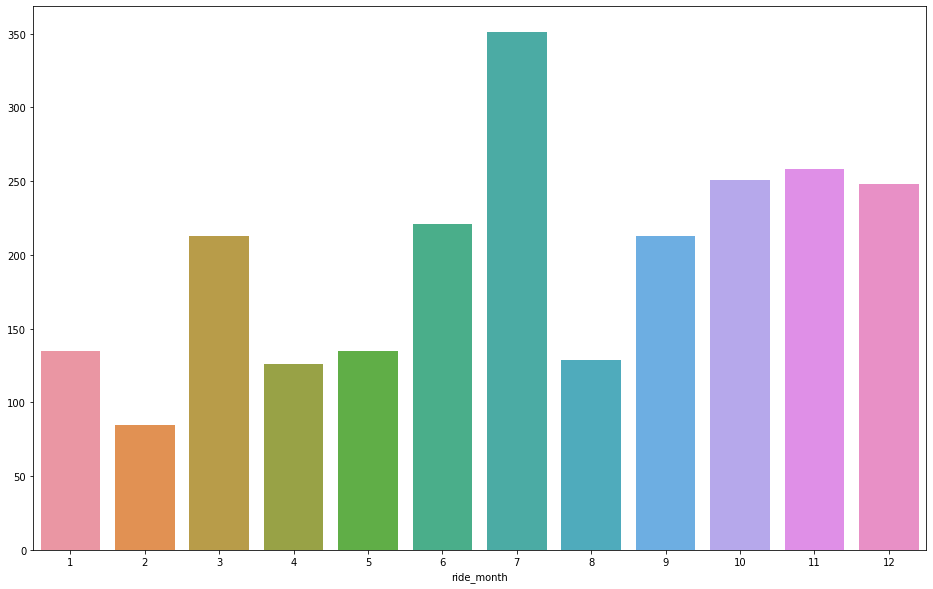

In [596]:
x = uio.groupby(['ride_month'])['id'].count() # There is some seasonality as the months of May to Jul and Nov-Dec have higher rides count
sns.barplot(x.index, x.values)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


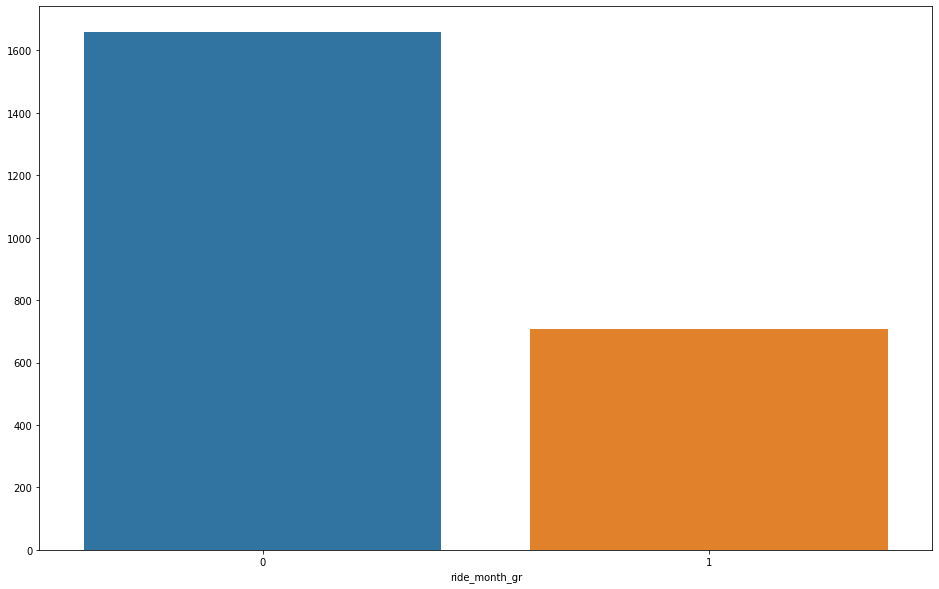

In [597]:
uio['ride_month_gr'] = uio['ride_month'].apply(lambda x: 1 if x in (1,6,7) else 0)
x = uio.groupby(['ride_month_gr'])['id'].count() # There is some seasonality as the months of May to Jul and Nov-Dec have higher rides count
sns.barplot(x.index, x.values)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


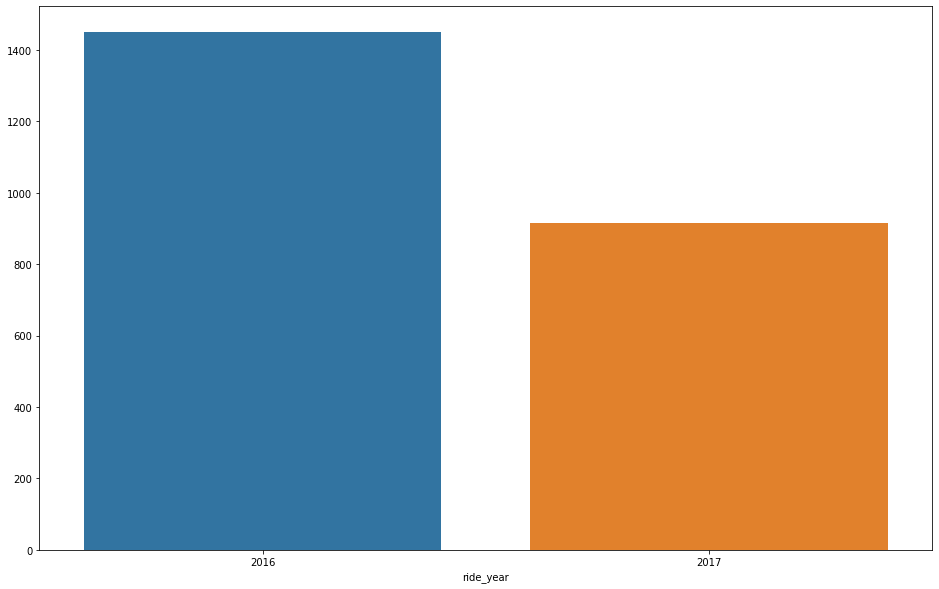

In [598]:
x = uio.groupby(['ride_year'])['id'].count() # There are more rides in 2017
sns.barplot(x.index, x.values)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


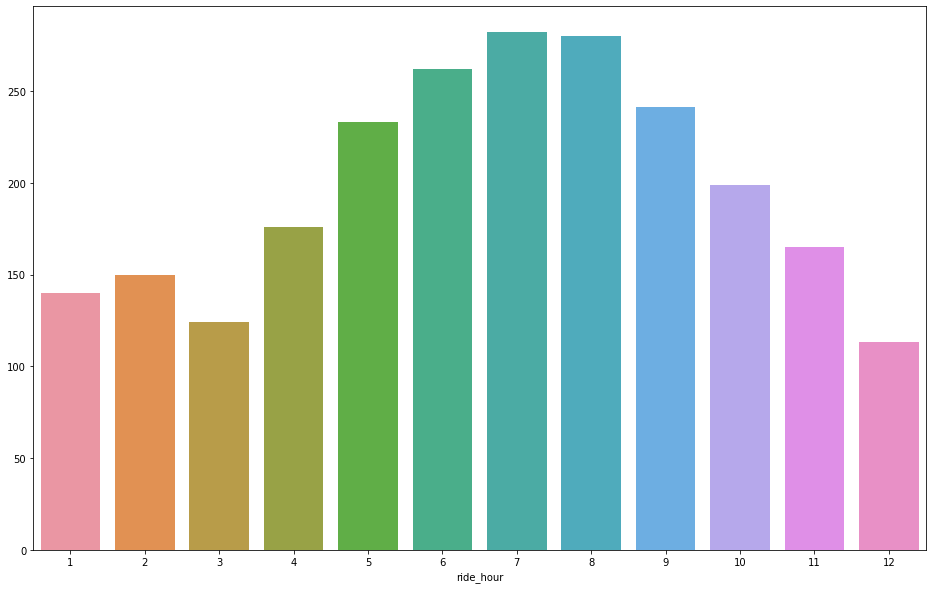

In [599]:
x = uio.groupby(['ride_hour'])['id'].count() # There is some seasonality based on the time of the day
sns.barplot(x.index, x.values)
plt.show()

In [600]:
uio['ride_hour_gr'] = uio['ride_hour'].apply(lambda x: 1 if x in (6,7,8,9) else 0)  #flag set to 1 if rides are booked in these hours

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


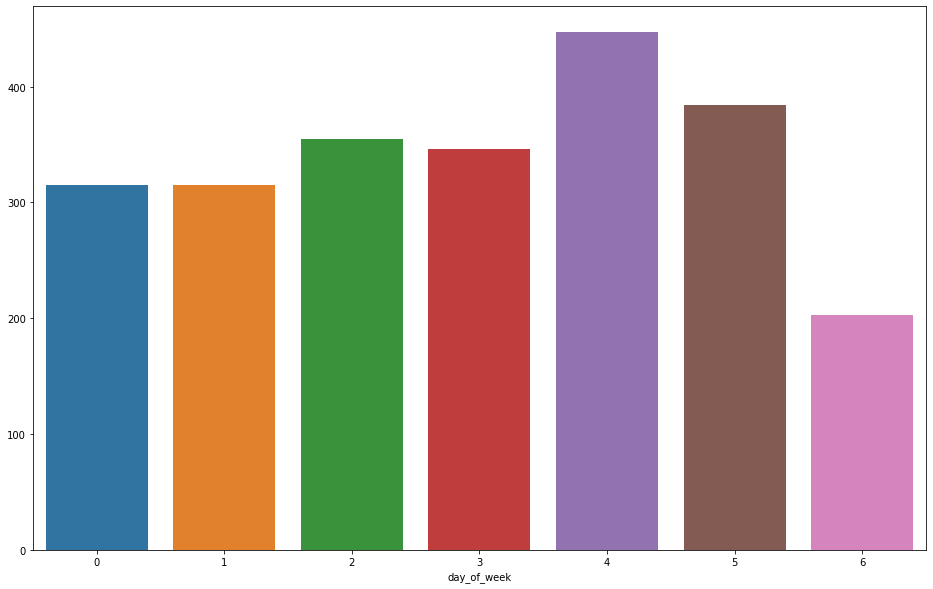

In [601]:
x = uio.groupby(['day_of_week'])['id'].count() # There is some seasonality as the months of May to Jul and Nov-Dec have higher rides count
sns.barplot(x.index, x.values)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


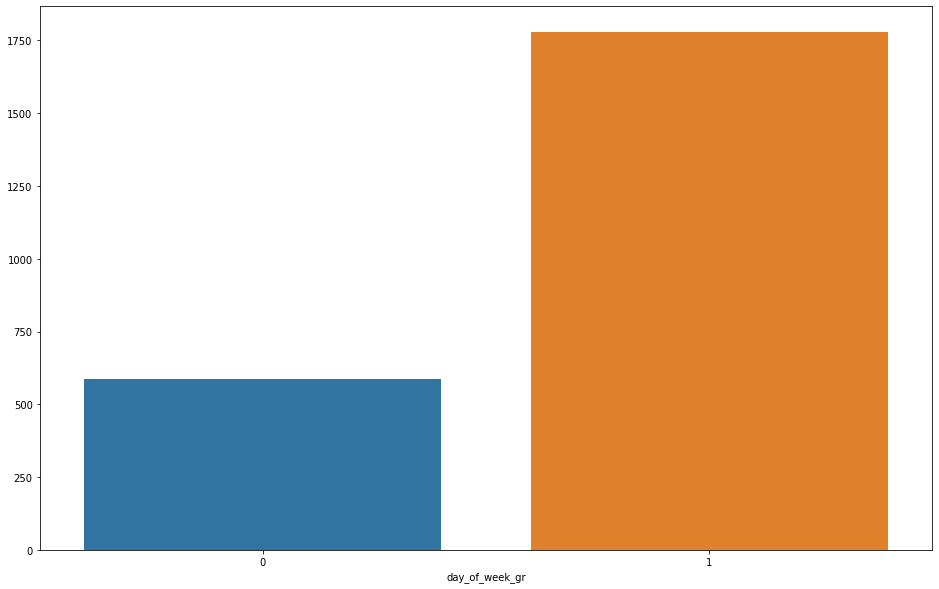

In [602]:
uio['day_of_week_gr'] = uio['day_of_week'].apply(lambda x: 1 if x in (0,1,2,3,4) else 0) # There is some seasonality as the months of May to Jul and Nov-Dec have higher rides count
x = uio.groupby(['day_of_week_gr'])['id'].count()
sns.barplot(x.index, x.values)

In [603]:
import math
def bearing_array(lat1, lng1, lat2, lng2):
    """bearing:
    horizontal angle between direction of an object and another object"""
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

In [604]:
uio.loc[:,'bearing'] = bearing_array(uio['pickup_latitude'].values, uio['pickup_longitude'].values, 
                               uio['dropoff_latitude'].values, uio['dropoff_longitude'].values)
uio.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,...,minute_grp,diff_longitude,diff_latitude,holiday,trip_duration_log,average_speed,ride_month_gr,ride_hour_gr,day_of_week_gr,bearing
0,1,BogotÃ¡,2016-09-18 01:54:11,2016-09-18 02:17:49,-74.1704,4.6227,-74.1193,4.5723,N,23.650000,...,4,0.0511,-0.0504,0,3.244544,30.279070,0,0,0,134.695132
1,2,BogotÃ¡,2016-09-18 03:31:05,2016-09-18 03:44:06,-74.1235,4.6041,-74.1161,4.5726,N,13.033333,...,3,0.0074,-0.0315,0,2.710270,32.690026,0,0,0,166.820350
3,4,BogotÃ¡,2016-09-18 04:31:13,2016-09-18 04:32:19,-74.1634,4.6419,-74.1658,4.6406,N,1.100000,...,3,-0.0024,-0.0013,0,1.131402,17.345455,0,0,0,-118.521714
5,6,BogotÃ¡,2016-09-18 05:39:06,2016-09-18 06:37:07,-74.0266,4.7614,-74.0866,4.5789,N,58.033333,...,3,-0.0600,-0.1824,0,4.094900,28.700747,0,0,0,-161.854841
6,7,BogotÃ¡,2016-09-18 07:33:15,2016-09-18 08:07:08,-74.1553,4.5997,-74.0382,4.7646,N,33.900000,...,3,0.1171,0.1649,0,3.580737,48.028319,0,1,0,35.284479


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

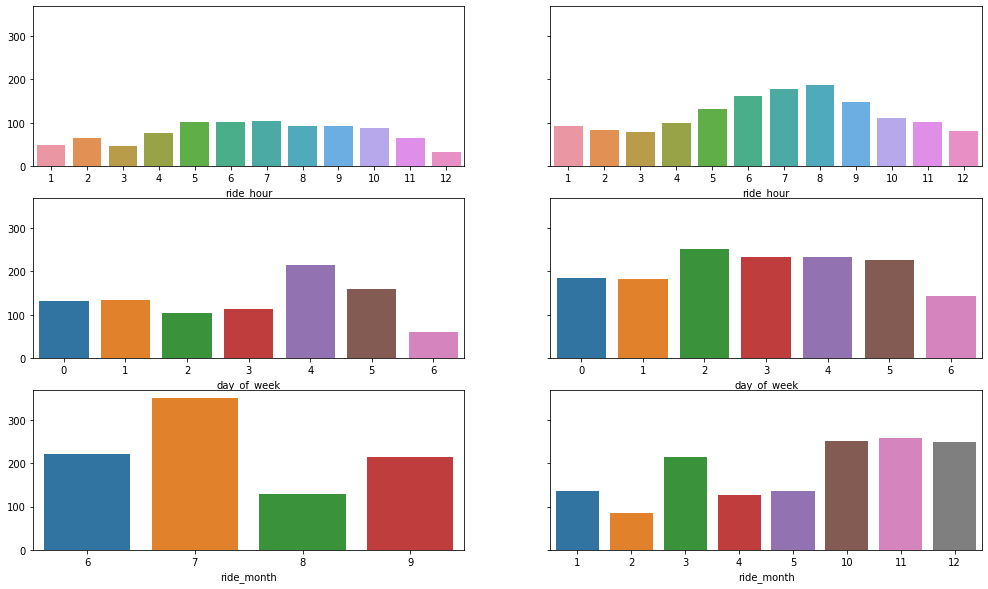

In [605]:
f, axes = plt.subplots(3,2,figsize=(17,10), sharey=True)

dat = uio[uio['season']==1].groupby(['ride_hour'])['id'].count()
fig1 = sns.barplot(dat.index, dat.values, ax=axes[0,0])
#fig1.set_ylim = 3000

dat = uio[uio['season']==0].groupby(['ride_hour'])['id'].count()
fig2 = sns.barplot(dat.index, dat.values, ax=axes[0,1])
#fig2.set_ylim = 3000

dat = uio[uio['season']==1].groupby(['day_of_week'])['id'].count()
fig1 = sns.barplot(dat.index, dat.values, ax=axes[1,0])
#fig1.set_ylim = 3000

dat = uio[uio['season']==0].groupby(['day_of_week'])['id'].count()
fig2 = sns.barplot(dat.index, dat.values, ax=axes[1,1])

dat = uio[uio['season']==1].groupby(['ride_month'])['id'].count()
fig1 = sns.barplot(dat.index, dat.values, ax=axes[2,0])
#fig1.set_ylim = 3000

dat = uio[uio['season']==0].groupby(['ride_month'])['id'].count()
fig2 = sns.barplot(dat.index, dat.values, ax=axes[2,1])

Getting Data Ready for the Model Build: 
* Create dummies
* Drop variables that are not useful for modeling eg. store_and_forward_flag, id, vendor_id
* Variables based on which dummies were created
* Variables that will cause leakage eg. dropoff_datetime, wait_time
* Two stage model can be built where first wait time is predicted and then using wait time and other independent variables predict the trip duration

In [606]:
uio = uio.drop(columns = ['vendor_id', 'dropoff_datetime', 'store_and_fwd_flag', 'pickup_datetime' ], axis=1)
uio.head()

,id,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,dist_meters,wait_sec,ride_length_grp,ride_month,...,minute_grp,diff_longitude,diff_latitude,holiday,trip_duration_log,average_speed,ride_month_gr,ride_hour_gr,day_of_week_gr,bearing
0,1,-74.1704,4.6227,-74.1193,4.5723,23.650000,11.935,4.883333,3,9,...,4,0.0511,-0.0504,0,3.244544,30.279070,0,0,0,134.695132
1,2,-74.1235,4.6041,-74.1161,4.5726,13.033333,7.101,2.316667,2,9,...,3,0.0074,-0.0315,0,2.710270,32.690026,0,0,0,166.820350
3,4,-74.1634,4.6419,-74.1658,4.6406,1.100000,0.318,0.866667,1,9,...,3,-0.0024,-0.0013,0,1.131402,17.345455,0,0,0,-118.521714
5,6,-74.0266,4.7614,-74.0866,4.5789,58.033333,27.760,13.266667,6,9,...,3,-0.0600,-0.1824,0,4.094900,28.700747,0,0,0,-161.854841
6,7,-74.1553,4.5997,-74.0382,4.7646,33.900000,27.136,3.583333,6,9,...,3,0.1171,0.1649,0,3.580737,48.028319,0,1,0,35.284479


In [607]:
uio.describe()

,id,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,dist_meters,wait_sec,ride_length_grp,ride_month,...,minute_grp,diff_longitude,diff_latitude,holiday,trip_duration_log,average_speed,ride_month_gr,ride_hour_gr,day_of_week_gr,bearing
count,2365.000000,2365.000000,2365.000000,2365.000000,2365.000000,2365.000000,2.365000e+03,2365.000000,2365.000000,2365.000000,...,2365.000000,2365.000000,2365.000000,2365.000000,2365.000000,2.365000e+03,2365.000000,2365.000000,2365.000000,2365.000000
mean,1527.801691,-74.098210,4.670462,-74.099438,4.669021,31.680867,-1.809114e+03,9.124651,1.967442,7.263848,...,2.403805,-0.001229,-0.001442,0.032981,3.027391,-8.091685e+03,0.298943,0.450317,0.751797,-4.986612
std,874.118137,0.138334,0.090196,0.139015,0.090580,38.186646,6.243654e+04,13.184123,1.354083,3.296627,...,1.110511,0.032798,0.043460,0.178625,1.024767,3.198950e+05,0.457892,0.497631,0.432062,105.365111
min,1.000000,-76.534400,3.393700,-76.542500,3.394600,0.500000,-2.147484e+06,0.000000,1.000000,1.000000,...,1.000000,-0.205400,-0.205700,0.000000,0.916291,-1.498244e+07,0.000000,0.000000,0.000000,-179.614989
25%,767.000000,-74.123300,4.629700,-74.119900,4.628000,8.733333,1.880000e+00,1.416667,1.000000,5.000000,...,1.000000,-0.013000,-0.012800,0.000000,2.373354,9.177089e+00,0.000000,0.000000,1.000000,-100.174987
50%,1541.000000,-74.085800,4.685000,-74.088700,4.677600,20.033333,5.139000e+00,4.383333,2.000000,7.000000,...,2.000000,0.000000,-0.000100,0.000000,3.092556,1.563038e+01,0.000000,0.000000,1.000000,0.000000
75%,2269.000000,-74.055100,4.714400,-74.058700,4.718300,39.483333,9.682000e+00,10.850000,2.000000,10.000000,...,3.000000,0.011100,0.012100,0.000000,3.725292,2.225806e+01,1.000000,1.000000,1.000000,86.531407
max,3062.000000,-73.831700,5.023900,-73.823800,5.024700,338.783333,4.968900e+01,98.433333,10.000000,12.000000,...,4.000000,0.149100,0.217300,1.000000,5.831247,3.645529e+02,1.000000,1.000000,1.000000,180.000000


In [608]:
np.percentile(uio['average_speed'], np.arange(0,101))

array([-1.49824441e+07,  1.59982970e-01,  3.66549700e-01,  6.57396808e-01,
        9.70896645e-01,  1.35620553e+00,  1.73935847e+00,  2.12614446e+00,
        2.37094054e+00,  2.83172576e+00,  3.19863278e+00,  3.60308998e+00,
        4.00690258e+00,  4.39872673e+00,  4.65792513e+00,  5.19249709e+00,
        5.66343677e+00,  6.24975376e+00,  6.80291877e+00,  7.07392553e+00,
        7.43958004e+00,  7.81177189e+00,  8.17633618e+00,  8.52625374e+00,
        8.83292955e+00,  9.17708895e+00,  9.52427078e+00,  9.81421275e+00,
        1.00735523e+01,  1.04024736e+01,  1.06997865e+01,  1.09834658e+01,
        1.12568251e+01,  1.14544335e+01,  1.17286755e+01,  1.19285484e+01,
        1.21354848e+01,  1.23855355e+01,  1.26347660e+01,  1.28944291e+01,
        1.31788396e+01,  1.34197760e+01,  1.37017524e+01,  1.40266428e+01,
        1.42772315e+01,  1.45428420e+01,  1.47696333e+01,  1.49459655e+01,
        1.51252037e+01,  1.53294108e+01,  1.56303797e+01,  1.58292267e+01,
        1.60525652e+01,  

In [609]:
uio = uio[uio['average_speed'] <= 150]
uio.shape

(2363, 27)

In [610]:
uio.describe()

,id,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,dist_meters,wait_sec,ride_length_grp,ride_month,...,minute_grp,diff_longitude,diff_latitude,holiday,trip_duration_log,average_speed,ride_month_gr,ride_hour_gr,day_of_week_gr,bearing
count,2363.000000,2363.000000,2363.000000,2363.000000,2363.000000,2363.000000,2.363000e+03,2363.000000,2363.000000,2363.000000,...,2363.000000,2363.000000,2363.000000,2363.000000,2363.000000,2.363000e+03,2363.000000,2363.000000,2363.000000,2363.000000
mean,1527.969953,-74.098161,4.670515,-74.099389,4.669074,31.706785,-1.810649e+03,9.131979,1.967837,7.265764,...,2.403724,-0.001230,-0.001443,0.033009,3.029008,-8.098780e+03,0.298773,0.450698,0.752010,-4.873488
std,873.990500,0.138359,0.090209,0.139042,0.090593,38.192407,6.246295e+04,13.187295,1.354510,3.296850,...,1.110882,0.032811,0.043478,0.178698,1.023692,3.200303e+05,0.457817,0.497669,0.431937,105.336988
min,1.000000,-76.534400,3.393700,-76.542500,3.394600,0.500000,-2.147484e+06,0.000000,1.000000,1.000000,...,1.000000,-0.205400,-0.205700,0.000000,0.916291,-1.498244e+07,0.000000,0.000000,0.000000,-179.614989
25%,767.500000,-74.123300,4.629750,-74.119850,4.628100,8.766667,1.880000e+00,1.416667,1.000000,5.000000,...,1.000000,-0.013000,-0.012850,0.000000,2.376454,9.175083e+00,0.000000,0.000000,1.000000,-100.130339
50%,1541.000000,-74.085800,4.685200,-74.088700,4.677600,20.050000,5.139000e+00,4.400000,2.000000,7.000000,...,2.000000,0.000000,-0.000100,0.000000,3.093313,1.560784e+01,0.000000,0.000000,1.000000,0.000000
75%,2268.000000,-74.055050,4.714450,-74.058700,4.718300,39.491667,9.691000e+00,10.858333,2.000000,10.000000,...,3.000000,0.011100,0.012100,0.000000,3.725493,2.225655e+01,1.000000,1.000000,1.000000,86.655248
max,3062.000000,-73.831700,5.023900,-73.823800,5.024700,338.783333,4.968900e+01,98.433333,10.000000,12.000000,...,4.000000,0.149100,0.217300,1.000000,5.831247,1.443214e+02,1.000000,1.000000,1.000000,180.000000


In [611]:
dat = uio
#dat = pd.concat([uio, ride_year, ride_month, ride_day, ride_hour, minute_grp], axis=1)
#dat.head()

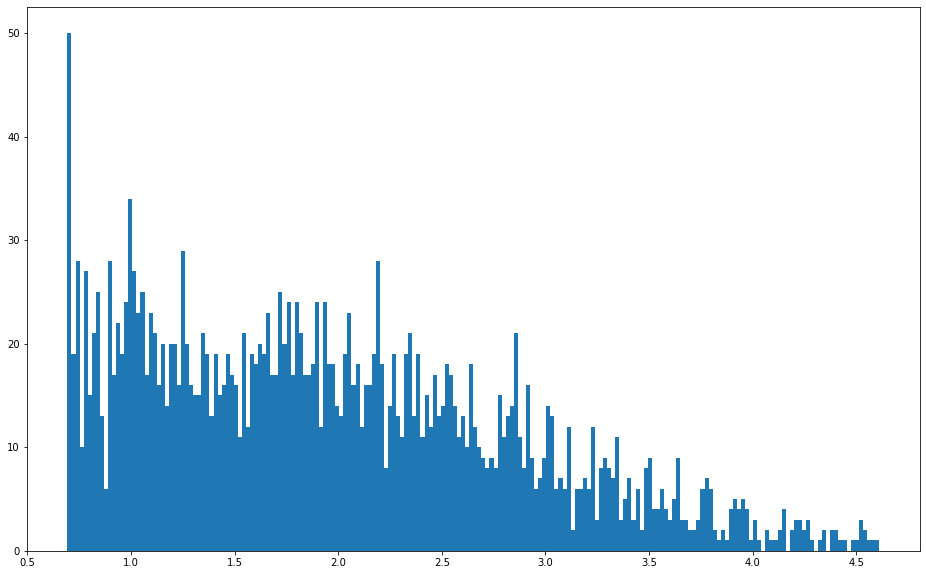

In [612]:
y = np.log1p(dat['wait_sec'] + 1)
x = dat.drop(['wait_sec'], axis = 1)
plt.hist(y, bins=200)
plt.show()

# **Clustering Coordinates** Ref 3 (most recommend)

In [613]:
from sklearn.cluster import KMeans

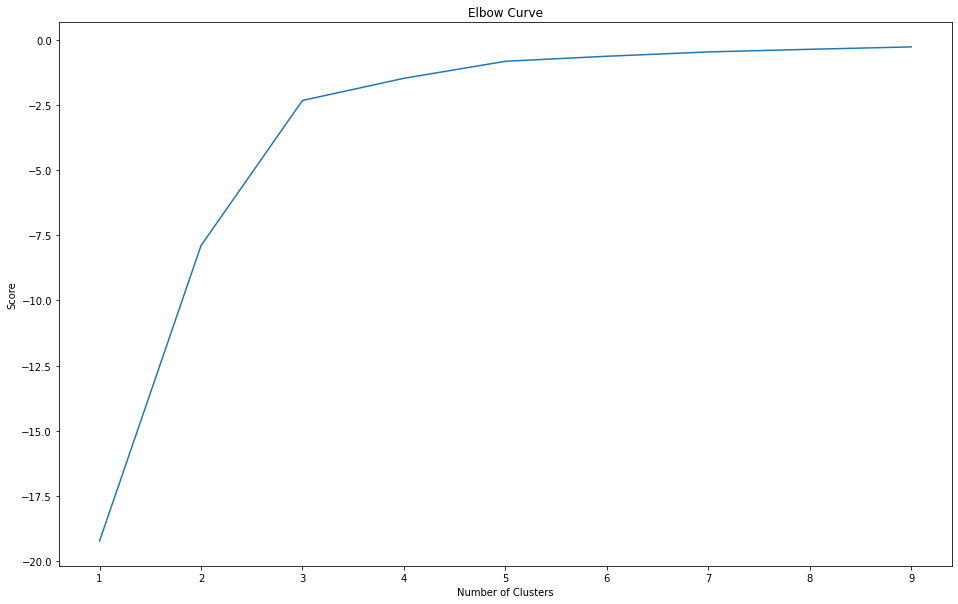

In [614]:
K_clusters = range(1,10)
kmeans = [KMeans(n_clusters=i) for i in K_clusters]
Y_axis = uio[['pickup_latitude']]
X_axis = uio[['pickup_longitude']]
score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]
# Visualize
plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [615]:
kmeans = KMeans(n_clusters = 3, init ='k-means++')
kmeans.fit(uio[['pickup_latitude', 'pickup_longitude']]) # Compute k-means clustering.
uio['cluster_pickup_ref3'] = kmeans.fit_predict(uio[['pickup_latitude', 'pickup_longitude']])
centers = kmeans.cluster_centers_ # Coordinates of cluster centers.
labels = kmeans.predict(uio[['pickup_latitude', 'pickup_longitude']]) # Labels of each point
uio.head(10)

,id,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,dist_meters,wait_sec,ride_length_grp,ride_month,...,diff_longitude,diff_latitude,holiday,trip_duration_log,average_speed,ride_month_gr,ride_hour_gr,day_of_week_gr,bearing,cluster_pickup_ref3
0,1,-74.1704,4.6227,-74.1193,4.5723,23.650000,11.935,4.883333,3,9,...,0.0511,-0.0504,0,3.244544,30.279070,0,0,0,134.695132,2
1,2,-74.1235,4.6041,-74.1161,4.5726,13.033333,7.101,2.316667,2,9,...,0.0074,-0.0315,0,2.710270,32.690026,0,0,0,166.820350,2
3,4,-74.1634,4.6419,-74.1658,4.6406,1.100000,0.318,0.866667,1,9,...,-0.0024,-0.0013,0,1.131402,17.345455,0,0,0,-118.521714,2
5,6,-74.0266,4.7614,-74.0866,4.5789,58.033333,27.760,13.266667,6,9,...,-0.0600,-0.1824,0,4.094900,28.700747,0,0,0,-161.854841,0
6,7,-74.1553,4.5997,-74.0382,4.7646,33.900000,27.136,3.583333,6,9,...,0.1171,0.1649,0,3.580737,48.028319,0,1,0,35.284479,2
7,8,-74.0492,4.7367,-74.0506,4.7187,3.183333,2.458,0.000000,1,9,...,-0.0015,-0.0180,0,1.645448,46.328796,0,0,0,-175.567629,0
8,9,-74.0493,4.7183,-74.0303,4.7109,5.133333,2.358,1.550000,1,9,...,0.0190,-0.0074,0,1.964779,27.561039,0,0,0,111.344576,0
9,10,-74.1290,4.6561,-74.1641,4.6237,18.100000,5.876,0.100000,2,9,...,-0.0351,-0.0324,0,3.000720,19.478453,0,1,1,-132.801720,2
11,12,-74.1073,4.6544,-74.1024,4.6159,27.383333,7.177,12.300000,2,9,...,0.0049,-0.0385,0,3.380428,15.725624,0,0,1,172.770078,2
13,14,-74.0507,4.7521,-74.0509,4.7520,15.150000,7.590,2.833333,2,9,...,-0.0002,-0.0001,0,2.841998,30.059406,0,0,1,-116.644041,0


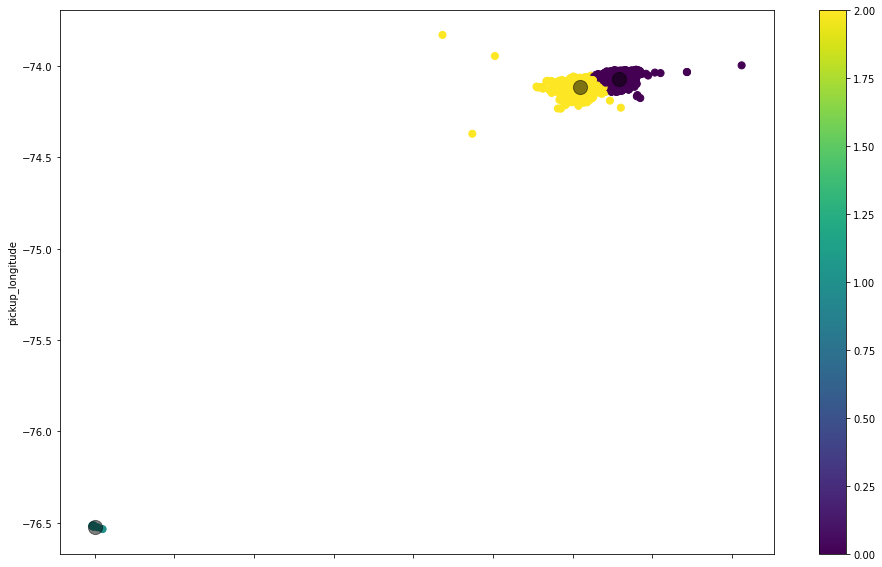

In [616]:
uio.plot.scatter(x = 'pickup_latitude', y = 'pickup_longitude', c=labels, s=50, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

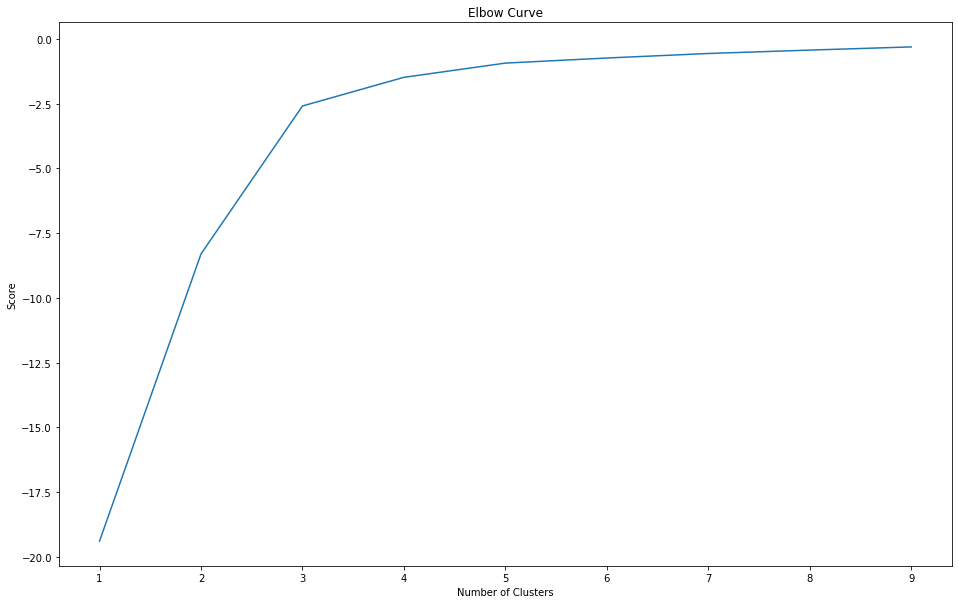

In [617]:
K_clusters = range(1,10)
kmeans = [KMeans(n_clusters=i) for i in K_clusters]
Y_axis = uio[['dropoff_latitude']]
X_axis = uio[['dropoff_longitude']]
score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]
# Visualize
plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [618]:
kmeans = KMeans(n_clusters = 3, init ='k-means++')
kmeans.fit(uio[['dropoff_latitude', 'dropoff_longitude']]) # Compute k-means clustering.
uio['cluster_dropoff_ref3'] = kmeans.fit_predict(uio[['dropoff_latitude', 'dropoff_longitude']])
centers = kmeans.cluster_centers_ # Coordinates of cluster centers.
labels = kmeans.predict(uio[['dropoff_latitude', 'dropoff_longitude']]) # Labels of each point
uio.head(10)

,id,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,dist_meters,wait_sec,ride_length_grp,ride_month,...,diff_latitude,holiday,trip_duration_log,average_speed,ride_month_gr,ride_hour_gr,day_of_week_gr,bearing,cluster_pickup_ref3,cluster_dropoff_ref3
0,1,-74.1704,4.6227,-74.1193,4.5723,23.650000,11.935,4.883333,3,9,...,-0.0504,0,3.244544,30.279070,0,0,0,134.695132,2,2
1,2,-74.1235,4.6041,-74.1161,4.5726,13.033333,7.101,2.316667,2,9,...,-0.0315,0,2.710270,32.690026,0,0,0,166.820350,2,2
3,4,-74.1634,4.6419,-74.1658,4.6406,1.100000,0.318,0.866667,1,9,...,-0.0013,0,1.131402,17.345455,0,0,0,-118.521714,2,2
5,6,-74.0266,4.7614,-74.0866,4.5789,58.033333,27.760,13.266667,6,9,...,-0.1824,0,4.094900,28.700747,0,0,0,-161.854841,0,2
6,7,-74.1553,4.5997,-74.0382,4.7646,33.900000,27.136,3.583333,6,9,...,0.1649,0,3.580737,48.028319,0,1,0,35.284479,2,0
7,8,-74.0492,4.7367,-74.0506,4.7187,3.183333,2.458,0.000000,1,9,...,-0.0180,0,1.645448,46.328796,0,0,0,-175.567629,0,0
8,9,-74.0493,4.7183,-74.0303,4.7109,5.133333,2.358,1.550000,1,9,...,-0.0074,0,1.964779,27.561039,0,0,0,111.344576,0,0
9,10,-74.1290,4.6561,-74.1641,4.6237,18.100000,5.876,0.100000,2,9,...,-0.0324,0,3.000720,19.478453,0,1,1,-132.801720,2,2
11,12,-74.1073,4.6544,-74.1024,4.6159,27.383333,7.177,12.300000,2,9,...,-0.0385,0,3.380428,15.725624,0,0,1,172.770078,2,2
13,14,-74.0507,4.7521,-74.0509,4.7520,15.150000,7.590,2.833333,2,9,...,-0.0001,0,2.841998,30.059406,0,0,1,-116.644041,0,0


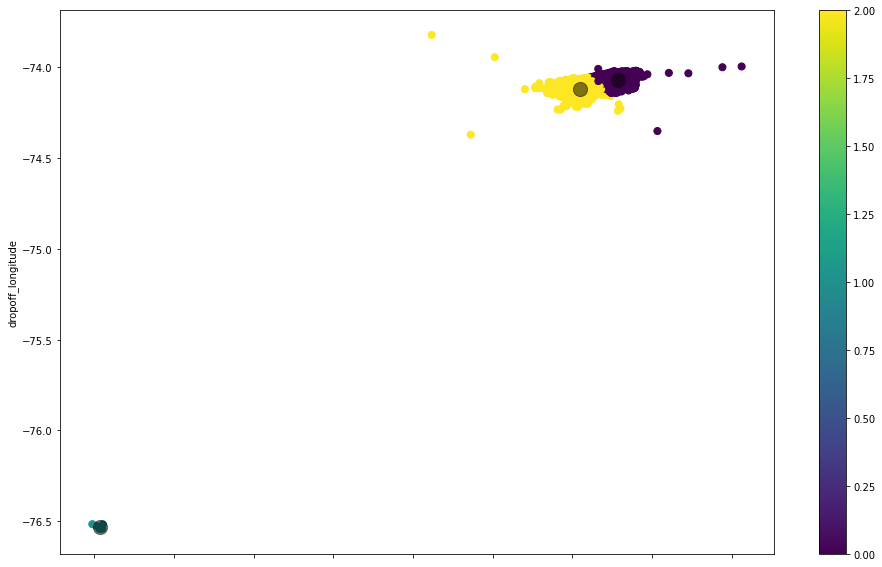

In [619]:
uio.plot.scatter(x = 'dropoff_latitude', y = 'dropoff_longitude', c=labels, s=50, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

# **Clustering Coordinate** Ref 2

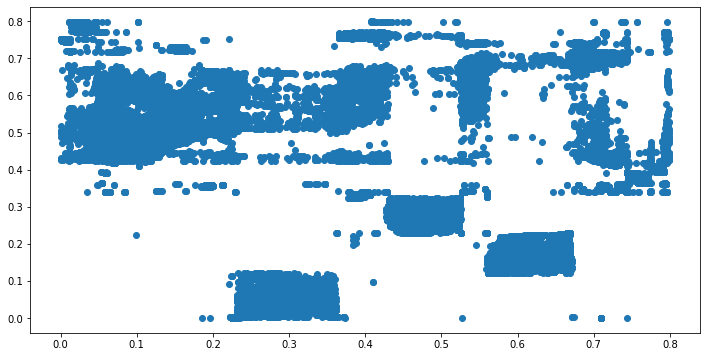

In [93]:
plt.figure(figsize=(12, 6))
plt.scatter(uio['pickup_latitude'], uio['pickup_longitude'])
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=3, random_state=10)

uio['cluster_ref2'] = kmeans.fit_predict(uio[['pickup_latitude', 'pickup_longitude']])

In [ ]:
plt.figure(figsize=(12, 6))
plt.scatter(uio['pickup_latitude'][uio['cluster_ref2'] == 0], uio['pickup_longitude'][uio['cluster_ref2'] == 0], c='r', label='c0')
plt.scatter(uio['pickup_latitude'][uio['cluster_ref2'] == 1], uio['pickup_longitude'][uio['cluster_ref2'] == 1], c='y', label='c1')
plt.scatter(uio['pickup_latitude'][uio['cluster_ref2'] == 2], uio['pickup_longitude'][uio['cluster_ref2'] == 2], c='g', label='c2')
plt.legend()
plt.show()

# **Cluestering Coordinate**  Ref 1

In [230]:
train_X, test_X, train_Y, test_Y = train_test_split(x, y, test_size = 0.2, shuffle=True, random_state = 65).copy()

In [231]:
print("Shape of X train", train_X.shape)
print("Shape of Y train", train_Y.shape)
print("Shape of X test", test_X.shape)
print("Shape of Y test", test_Y.shape)

Shape of X train (61018, 26)
Shape of Y train (61018,)
Shape of X test (15255, 26)
Shape of Y test (15255,)


In [232]:
coordinates = np.vstack((train_X[['pickup_latitude', 'pickup_longitude']].values, train_X[['dropoff_latitude', 'dropoff_longitude']].values))

In [233]:
scaler = StandardScaler()
coordinates_std = scaler.fit_transform(coordinates)
clustering = MiniBatchKMeans(n_clusters=70, random_state=203, batch_size=10000)
model = clustering.fit(coordinates_std)

In [234]:
X_Tr = train_X.copy().reset_index().drop('index', axis=1)
Y_Tr = train_Y.copy().reset_index().drop('index', axis=1)
X_Te = test_X.copy().reset_index().drop('index', axis=1)
Y_Te = test_Y.copy().reset_index().drop('index', axis=1)

X_Tr['kms_pick_cluster'] = pd.Series(model.predict(scaler.fit_transform(X_Tr[['pickup_latitude', 'pickup_longitude']])))
X_Tr['kms_drop_cluster'] = pd.Series(model.predict(scaler.fit_transform(X_Tr[['dropoff_latitude', 'dropoff_longitude']])))
X_Te['kms_pick_cluster'] = pd.Series(model.predict(scaler.fit_transform(X_Te[['pickup_latitude', 'pickup_longitude']])))
X_Te['kms_drop_cluster'] = pd.Series(model.predict(scaler.fit_transform(X_Te[['dropoff_latitude', 'dropoff_longitude']])))

In [235]:
X_Tr.head()

,id,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,dist_meters,ride_length_grp,ride_month,ride_year,...,diff_latitude,holiday,trip_duration_log,average_speed,ride_month_gr,ride_hour_gr,day_of_week_gr,bearing,kms_pick_cluster,kms_drop_cluster
0,29689,0.0557,0.3350,-99.1643,19.4238,13.650000,5.997,2,7,2017,...,19.0888,0,2.750471,26.360440,1,0,1,-70.293446,12,13
1,45033,0.4700,0.0857,-78.4754,-0.1644,23.466667,4.356,1,12,2016,...,-0.2500,0,3.237370,11.137500,0,1,1,-90.184251,19,50
2,30690,0.7308,0.1474,-78.6430,-1.6821,7.900000,7.209,2,7,2017,...,-1.8295,0,2.292535,54.751899,1,0,1,-91.739056,32,19
3,71862,0.1176,0.2620,-99.2700,19.3249,3.550000,0.783,1,1,2017,...,19.0629,0,1.713798,13.233803,1,1,0,-70.394328,12,13
4,52120,0.2234,0.6279,-100.5133,25.7026,6.133333,2.935,1,7,2016,...,25.0747,0,2.095971,28.711957,1,0,1,-63.805201,13,61


In [236]:
X_Te.head()

,id,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,dist_meters,ride_length_grp,ride_month,ride_year,...,diff_latitude,holiday,trip_duration_log,average_speed,ride_month_gr,ride_hour_gr,day_of_week_gr,bearing,kms_pick_cluster,kms_drop_cluster
0,49333,0.1760,0.5677,-100.3043,25.6293,32.866667,11.005,3,2,2017,...,25.0616,0,3.551531,20.090264,0,0,0,-63.909160,13,61
1,56993,0.4143,0.7216,-76.5215,3.4645,28.266667,11.451,3,2,2017,...,2.7429,0,3.410047,24.306368,0,0,1,-86.610789,61,37
2,52742,0.3691,0.7635,-74.0485,4.7287,6.733333,2.789,1,8,2016,...,3.9652,0,2.167147,24.852475,0,0,1,-85.303586,61,34
3,948,0.5428,0.1154,-78.4883,-0.2011,23.566667,7.332,2,4,2017,...,-0.3165,0,3.241289,18.667044,0,0,1,-90.227208,32,50
4,15624,0.0545,0.3229,-99.0904,19.4479,21.016667,11.290,3,11,2016,...,19.1251,0,3.136219,32.231562,0,0,0,-70.275067,12,13


In [237]:

print(X_Tr.shape)
print(Y_Tr.shape)
print(X_Te.shape)
print(Y_Te.shape)

print(X_Tr['kms_pick_cluster'].isna().sum())
print(X_Tr['kms_drop_cluster'].isna().sum())
print(X_Te['kms_pick_cluster'].isna().sum())
print(X_Te['kms_drop_cluster'].isna().sum())

(61018, 28)
(61018, 1)
(15255, 28)
(15255, 1)
0
0
0
0


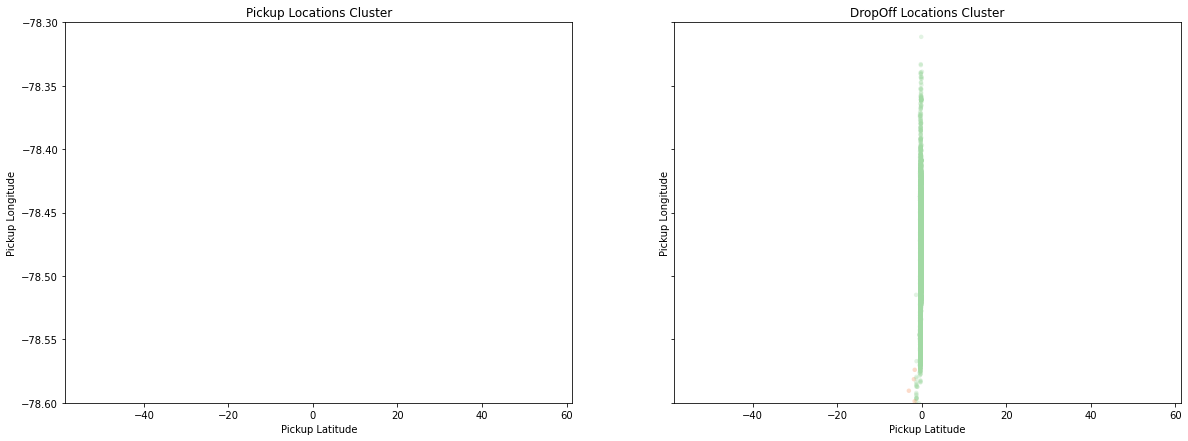

In [238]:
fig, axes = plt.subplots(1, 2, figsize=(20, 7), sharex=True, sharey=True)
axes[0].scatter(X_Tr['pickup_latitude'], X_Tr['pickup_longitude'], c=X_Tr['kms_pick_cluster'], alpha=0.3, lw = 0, s=20, cmap='Spectral')
axes[0].set_title('Pickup Locations Cluster')
axes[0].set_xlabel('Pickup Latitude')
axes[0].set_ylabel('Pickup Longitude')
axes[0].set_ylim([-78.6, -78.3])

axes[1].scatter(X_Tr['dropoff_latitude'], X_Tr['dropoff_longitude'], c=X_Tr['kms_drop_cluster'], alpha=0.3, lw = 0, s=20, cmap='Spectral')
axes[1].set_title('DropOff Locations Cluster')
axes[1].set_xlabel('Pickup Latitude')
axes[1].set_ylabel('Pickup Longitude')
plt.show()

In [239]:
X_Tr.head()

,id,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,dist_meters,ride_length_grp,ride_month,ride_year,...,diff_latitude,holiday,trip_duration_log,average_speed,ride_month_gr,ride_hour_gr,day_of_week_gr,bearing,kms_pick_cluster,kms_drop_cluster
0,29689,0.0557,0.3350,-99.1643,19.4238,13.650000,5.997,2,7,2017,...,19.0888,0,2.750471,26.360440,1,0,1,-70.293446,12,13
1,45033,0.4700,0.0857,-78.4754,-0.1644,23.466667,4.356,1,12,2016,...,-0.2500,0,3.237370,11.137500,0,1,1,-90.184251,19,50
2,30690,0.7308,0.1474,-78.6430,-1.6821,7.900000,7.209,2,7,2017,...,-1.8295,0,2.292535,54.751899,1,0,1,-91.739056,32,19
3,71862,0.1176,0.2620,-99.2700,19.3249,3.550000,0.783,1,1,2017,...,19.0629,0,1.713798,13.233803,1,1,0,-70.394328,12,13
4,52120,0.2234,0.6279,-100.5133,25.7026,6.133333,2.935,1,7,2016,...,25.0747,0,2.095971,28.711957,1,0,1,-63.805201,13,61


# **Hasil Akhir Tabel**

In [620]:
uio.head()

,id,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,dist_meters,wait_sec,ride_length_grp,ride_month,...,diff_latitude,holiday,trip_duration_log,average_speed,ride_month_gr,ride_hour_gr,day_of_week_gr,bearing,cluster_pickup_ref3,cluster_dropoff_ref3
0,1,-74.1704,4.6227,-74.1193,4.5723,23.650000,11.935,4.883333,3,9,...,-0.0504,0,3.244544,30.279070,0,0,0,134.695132,2,2
1,2,-74.1235,4.6041,-74.1161,4.5726,13.033333,7.101,2.316667,2,9,...,-0.0315,0,2.710270,32.690026,0,0,0,166.820350,2,2
3,4,-74.1634,4.6419,-74.1658,4.6406,1.100000,0.318,0.866667,1,9,...,-0.0013,0,1.131402,17.345455,0,0,0,-118.521714,2,2
5,6,-74.0266,4.7614,-74.0866,4.5789,58.033333,27.760,13.266667,6,9,...,-0.1824,0,4.094900,28.700747,0,0,0,-161.854841,0,2
6,7,-74.1553,4.5997,-74.0382,4.7646,33.900000,27.136,3.583333,6,9,...,0.1649,0,3.580737,48.028319,0,1,0,35.284479,2,0


In [621]:
uio.describe()

,id,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,dist_meters,wait_sec,ride_length_grp,ride_month,...,diff_latitude,holiday,trip_duration_log,average_speed,ride_month_gr,ride_hour_gr,day_of_week_gr,bearing,cluster_pickup_ref3,cluster_dropoff_ref3
count,2363.000000,2363.000000,2363.000000,2363.000000,2363.000000,2363.000000,2.363000e+03,2363.000000,2363.000000,2363.000000,...,2363.000000,2363.000000,2363.000000,2.363000e+03,2363.000000,2363.000000,2363.000000,2363.000000,2363.000000,2363.000000
mean,1527.969953,-74.098161,4.670515,-74.099389,4.669074,31.706785,-1.810649e+03,9.131979,1.967837,7.265764,...,-0.001443,0.033009,3.029008,-8.098780e+03,0.298773,0.450698,0.752010,-4.873488,0.844266,0.866272
std,873.990500,0.138359,0.090209,0.139042,0.090593,38.192407,6.246295e+04,13.187295,1.354510,3.296850,...,0.043478,0.178698,1.023692,3.200303e+05,0.457817,0.497669,0.431937,105.336988,0.986507,0.989732
min,1.000000,-76.534400,3.393700,-76.542500,3.394600,0.500000,-2.147484e+06,0.000000,1.000000,1.000000,...,-0.205700,0.000000,0.916291,-1.498244e+07,0.000000,0.000000,0.000000,-179.614989,0.000000,0.000000
25%,767.500000,-74.123300,4.629750,-74.119850,4.628100,8.766667,1.880000e+00,1.416667,1.000000,5.000000,...,-0.012850,0.000000,2.376454,9.175083e+00,0.000000,0.000000,1.000000,-100.130339,0.000000,0.000000
50%,1541.000000,-74.085800,4.685200,-74.088700,4.677600,20.050000,5.139000e+00,4.400000,2.000000,7.000000,...,-0.000100,0.000000,3.093313,1.560784e+01,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,2268.000000,-74.055050,4.714450,-74.058700,4.718300,39.491667,9.691000e+00,10.858333,2.000000,10.000000,...,0.012100,0.000000,3.725493,2.225655e+01,1.000000,1.000000,1.000000,86.655248,2.000000,2.000000
max,3062.000000,-73.831700,5.023900,-73.823800,5.024700,338.783333,4.968900e+01,98.433333,10.000000,12.000000,...,0.217300,1.000000,5.831247,1.443214e+02,1.000000,1.000000,1.000000,180.000000,2.000000,2.000000


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


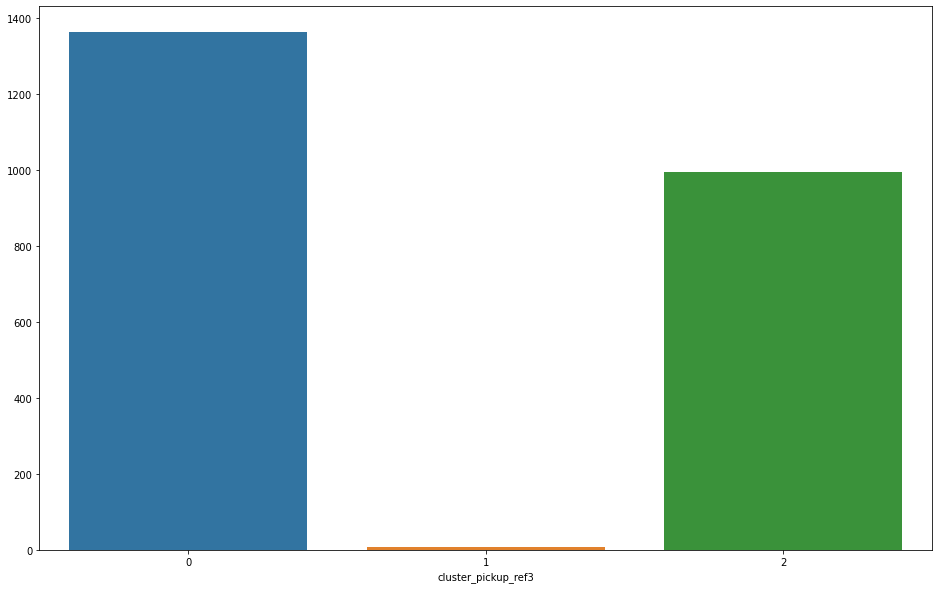

In [622]:
x = uio.groupby(['cluster_pickup_ref3'])['id'].count()
sns.barplot(x.index, x.values)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


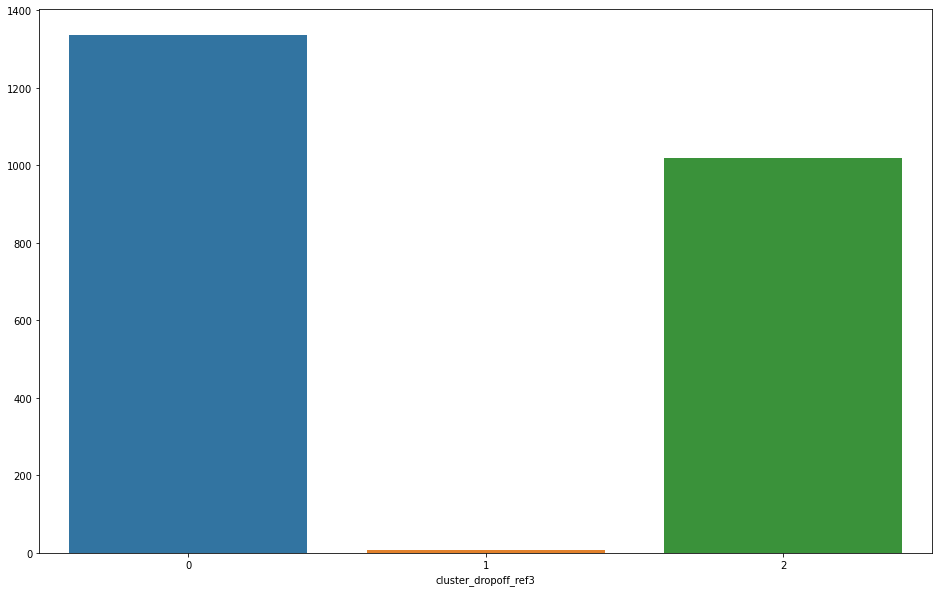

In [623]:
x = uio.groupby(['cluster_dropoff_ref3'])['id'].count()
sns.barplot(x.index, x.values)
plt.show()

In [624]:
uio = uio.drop(columns = ['id'], axis=1)

In [625]:
uio.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,dist_meters,wait_sec,ride_length_grp,ride_month,ride_year,...,diff_latitude,holiday,trip_duration_log,average_speed,ride_month_gr,ride_hour_gr,day_of_week_gr,bearing,cluster_pickup_ref3,cluster_dropoff_ref3
0,-74.1704,4.6227,-74.1193,4.5723,23.650000,11.935,4.883333,3,9,2016,...,-0.0504,0,3.244544,30.279070,0,0,0,134.695132,2,2
1,-74.1235,4.6041,-74.1161,4.5726,13.033333,7.101,2.316667,2,9,2016,...,-0.0315,0,2.710270,32.690026,0,0,0,166.820350,2,2
3,-74.1634,4.6419,-74.1658,4.6406,1.100000,0.318,0.866667,1,9,2016,...,-0.0013,0,1.131402,17.345455,0,0,0,-118.521714,2,2
5,-74.0266,4.7614,-74.0866,4.5789,58.033333,27.760,13.266667,6,9,2016,...,-0.1824,0,4.094900,28.700747,0,0,0,-161.854841,0,2
6,-74.1553,4.5997,-74.0382,4.7646,33.900000,27.136,3.583333,6,9,2016,...,0.1649,0,3.580737,48.028319,0,1,0,35.284479,2,0


In [626]:
#uio = uio.drop(columns = ['trip_duration_log'], axis=1)

# **Split Data** Ref 4

In [627]:
train_dataset = uio.sample(frac=0.8, random_state=0)
test_dataset = uio.drop(train_dataset.index)

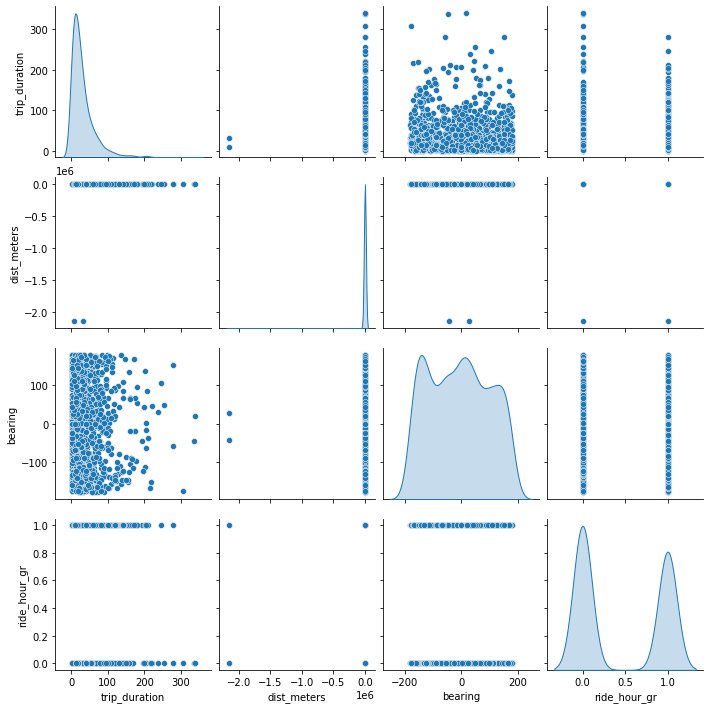

In [628]:
sns.pairplot(train_dataset[['trip_duration', 'dist_meters', 'bearing','ride_hour_gr']], diag_kind='kde')

In [629]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
pickup_longitude,1890.0,-74.100206,0.153305,-7.653440e+01,-74.123500,-74.086000,-74.055425,-73.831700
pickup_latitude,1890.0,4.669921,0.096720,3.393700e+00,4.629800,4.686250,4.715650,4.886600
dropoff_longitude,1890.0,-74.101461,0.154027,-7.654250e+01,-74.119650,-74.088900,-74.059400,-73.823800
dropoff_latitude,1890.0,4.668074,0.096842,3.394600e+00,4.628200,4.677950,4.718300,4.976500
trip_duration,1890.0,31.724480,37.320329,5.000000e-01,8.870833,20.333333,39.962500,338.783333
dist_meters,1890.0,-2265.546405,69839.380928,-2.147484e+06,1.909000,5.130500,9.695500,49.689000
wait_sec,1890.0,9.206746,13.192349,0.000000e+00,1.433333,4.483333,10.908333,98.433333
ride_length_grp,1890.0,1.959259,1.336039,1.000000e+00,1.000000,2.000000,2.000000,10.000000
ride_month,1890.0,7.258201,3.282370,1.000000e+00,5.000000,7.000000,10.000000,12.000000
ride_year,1890.0,2016.385714,0.486892,2.016000e+03,2016.000000,2016.000000,2017.000000,2017.000000


In [630]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('trip_duration')
test_labels = test_features.pop('trip_duration')

In [631]:
#train_features.pop('trip_duration_log')

#train_features.describe().transpose()[['mean', 'std']]

In [632]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
pickup_longitude,-74.100206,0.153305
pickup_latitude,4.669921,0.096720
dropoff_longitude,-74.101461,0.154027
dropoff_latitude,4.668074,0.096842
trip_duration,31.724480,37.320329
dist_meters,-2265.546405,69839.380928
wait_sec,9.206746,13.192349
ride_length_grp,1.959259,1.336039
ride_month,7.258201,3.282370
ride_year,2016.385714,0.486892


In [633]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

In [634]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))
print(normalizer.mean.numpy())

[[-7.41002274e+01  4.66992140e+00 -7.41014633e+01  4.66807461e+00
  -2.26554639e+03  9.20674515e+00  1.95925915e+00  7.25820065e+00
   2.01638611e+03  1.58015881e+01  6.72962856e+00  2.85158768e+01
   2.93915367e+00  3.86243373e-01  0.00000000e+00  2.39523721e+00
  -1.25619059e-03 -1.84820103e-03  3.38624455e-02  3.03785133e+00
  -1.01298955e+04  2.94179916e-01  4.50793713e-01  7.53439367e-01
  -6.82236099e+00  8.33333433e-01  8.65079463e-01]]


In [635]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[ -74.12    4.59  -74.12    4.62    4.39    0.9     1.     11.   2016.
    12.     11.      4.      5.      0.      0.      1.      0.      0.03
     0.      2.41   28.97    0.      0.      0.      5.95    2.      2.  ]]

Normalized: [[-0.15 -0.81 -0.12 -0.5   0.03 -0.63 -0.72  1.14 -0.79 -0.42  1.41 -1.42
   1.1  -0.79  0.   -1.25  0.13  0.7  -0.19 -0.62  0.03 -0.65 -0.91 -1.75
   0.12  1.19  1.15]]


# **Regression** Ref 4.1

In [636]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

linear_model.predict(train_features[:10])

linear_model.layers[1].kernel

<tf.Variable 'dense_9/kernel:0' shape=(27, 1) dtype=float32, numpy=
array([[-0.44898447],
       [-0.3246093 ],
       [ 0.2652269 ],
       [ 0.44751894],
       [ 0.33388042],
       [ 0.18368822],
       [ 0.17484152],
       [-0.2999422 ],
       [ 0.0118539 ],
       [ 0.36290115],
       [ 0.24743366],
       [-0.05477437],
       [-0.20900178],
       [-0.22760037],
       [ 0.31386107],
       [-0.4560947 ],
       [ 0.23878986],
       [ 0.45783353],
       [ 0.38368434],
       [ 0.24799156],
       [ 0.30183786],
       [ 0.3626395 ],
       [ 0.45291144],
       [-0.4397479 ],
       [ 0.17049283],
       [ 0.10366976],
       [ 0.14344239]], dtype=float32)>

In [637]:
linear_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [638]:
%%time
history = linear_model.fit(
    train_features,
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

CPU times: user 10.1 s, sys: 620 ms, total: 10.8 s
Wall time: 9.21 s


In [639]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [trip_duration]')
  plt.legend()
  plt.grid(True)

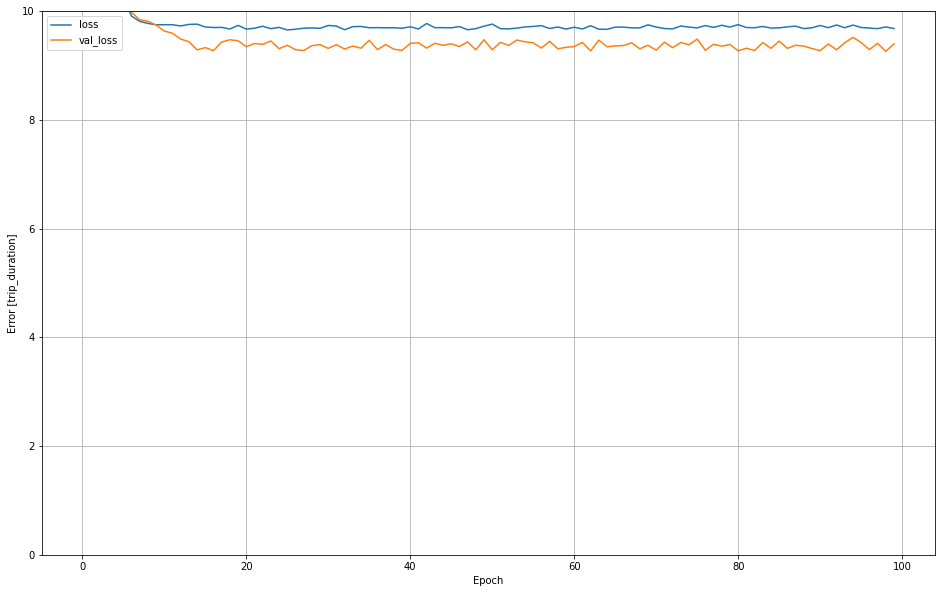

In [640]:
plot_loss(history)

In [641]:
test_results = {}

In [642]:
test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=0)

# **Regression** Ref 4.2

In [ ]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [ ]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

In [ ]:
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

In [ ]:
plot_loss(history)

In [ ]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

In [ ]:
pd.DataFrame(test_results, index=['Mean absolute error [trip_duration]']).T

In [ ]:
pd.DataFrame(test_results, index=['Mean absolute error [trip_duration]']).T

# **Make Predition** Ref 4

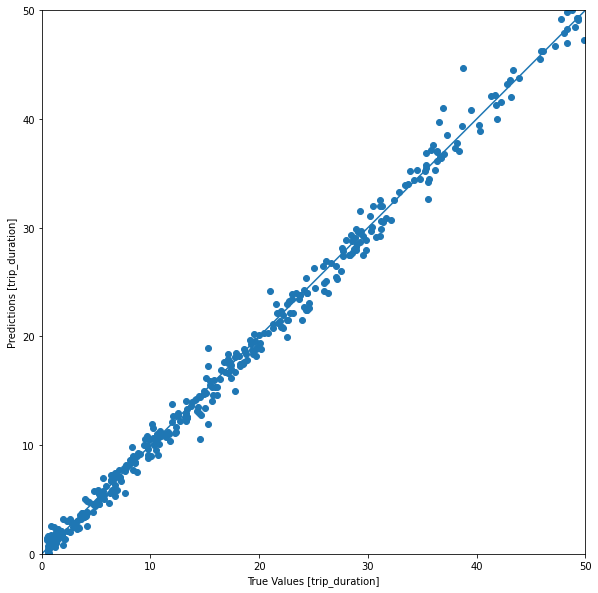

In [378]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [trip_duration]')
plt.ylabel('Predictions [trip_duration]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

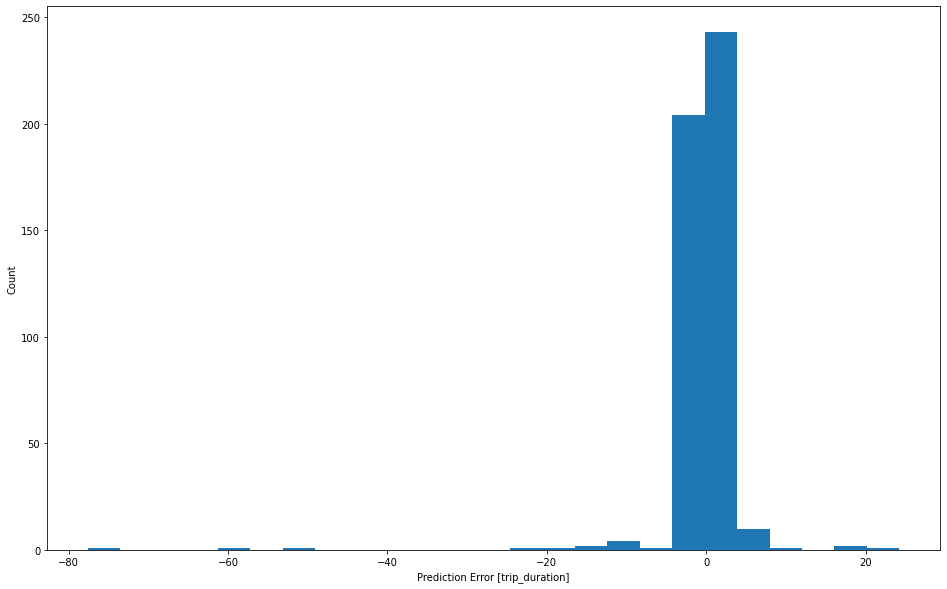

In [380]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [trip_duration]')
_ = plt.ylabel('Count')

# **Prediction**

In [87]:
d_Tr = xgb.DMatrix(X_Tr, label=Y_Tr)
d_Te = xgb.DMatrix(X_Te)

In [88]:
def xgb_evaluate(max_depth, gamma,min_child_weight,max_delta_step,subsample,colsample_bytree, eta):
    params = {'eval_metric': 'rmse',
                  'max_depth': int(max_depth),
                  'subsample': subsample,
                  'eta': eta,
                  'gamma': gamma,
                  'colsample_bytree': colsample_bytree,   
                  'min_child_weight': min_child_weight ,
                  'max_delta_step':max_delta_step
                 }
    # Use cross validation to avoid over fitting
    cv_result = xgb.cv(params, d_Tr, num_boost_round=1000, nfold=3, metrics = "rmse", early_stopping_rounds=10, seed=3113)    
    print("Number of Trees", cv_result.shape[0])
        
    # Returning negative of RMSE since Bayesian optimization only knows how to maximize
    return -1.0 * cv_result['test-rmse-mean'].iloc[-1]

In [89]:
%%time
xgb_bo = BayesianOptimization(xgb_evaluate, {
    'eta': (0.01, 0.1),
    'max_depth': (2, 6),
    'gamma': (0, 5),
    'min_child_weight': (1, 20),
    'max_delta_step': (0, 10),
    'subsample': (0.2, 1),
    'colsample_bytree' :(0.2, 0.8)})

# Use the expected improvement acquisition function to handle negative numbers
# Optimally needs quite a few more initiation points and number of iterations
xgb_bo.maximize(init_points=5, n_iter=50, acq='ei')

|   iter    |  target   | colsam... |    eta    |   gamma   | max_de... | max_depth | min_ch... | subsample |
-------------------------------------------------------------------------------------------------------------
Number of Trees 331
|  1        | -0.4623   |  0.4314   |  0.07419  |  2.981    |  0.4399   |  2.786    |  10.91    |  0.2837   |
Number of Trees 121
|  2        | -0.4548   |  0.5737   |  0.07707  |  1.029    |  9.796    |  5.027    |  9.769    |  0.7919   |
Number of Trees 212
|  3        | -0.4578   |  0.3266   |  0.06098  |  3.657    |  0.6567   |  5.103    |  7.819    |  0.4112   |
Number of Trees 151
|  4        | -0.4562   |  0.726    |  0.08276  |  2.892    |  2.925    |  4.313    |  7.758    |  0.686    |
Number of Trees 170
|  5        | -0.4562   |  0.4521   |  0.09537  |  3.979    |  2.989    |  4.672    |  15.78    |  0.7434   |
Number of Trees 299
|  6        | -0.4572   |  0.213    |  0.0768   |  4.313    |  8.675    |  5.708    |  1.447    |  0.7077   |


KeyboardInterrupt: ignored

In [ ]:
params = xgb_bo.max['params']
print(params)

In [ ]:
params['max_depth'] = int(params['max_depth'])

In [ ]:
# Train a new model with the best parameters from the search
model2 = xgb.train(params, d_Tr, num_boost_round=650)

# Predict on testing and training set
y_pred_xgb = model2.predict(d_Te)
y_train_pred_xgb = model2.predict(d_Tr)

In [ ]:
# Report testing and training RMSE
print('Test error:', np.sqrt(mean_squared_error(Y_Te, y_pred_xgb)))
print('Train error:', np.sqrt(mean_squared_error(Y_Tr, y_train_pred_xgb)))


In [ ]:
sns.distplot(y_pred_xgb, label='y_hat')
sns.distplot(Y_Te, label='y')
plt.legend()
sns.despine()
plt.tight_layout();

In [ ]:

wait_sec_train = (np.expm1(Y_Tr)*60).round()
np.quantile(wait_sec_train, [0, 0.05, 0.5, 0.95, 0.99])

In [ ]:
wait_sec_true = (np.expm1(Y_Te)*60).round()
wait_sec_predicted = (np.expm1(y_pred_xgb)*60).round()


In [ ]:
wait_sec_predicted

In [ ]:
wait_sec_true = np.array(wait_sec_true).T[0]
residual = wait_sec_predicted - wait_sec_true.T
wait_sec_true

In [ ]:
residual

In [ ]:
fig = plt.figure(num=None, figsize=(12, 4), dpi=80, facecolor='w', edgecolor='k')

plt.subplot(1, 2, 1)
ax1 = sns.distplot(residual)
ax1.set_title('Distribution of residuals\n')
ax1.set_xlabel('')

plt.subplot(1, 2, 2)
ax2 = sns.boxplot(residual, showfliers=False)
ax2.set_xlabel('')

sns.despine()
plt.tight_layout()

In [ ]:
print("Mean absolute error:", np.abs(residual).mean())

In [ ]:
# feature importance
fig =  plt.figure(figsize = (12,8))
axes = fig.add_subplot(111)
xgb.plot_importance(model2,ax = axes,height =0.5)
sns.despine()
plt.tight_layout()

In [ ]:
featuresImp = model2.get_score(importance_type='gain')
print(featuresImp)

Elastic Net Model

In [ ]:
grid_search = GridSearchCV( 
                              estimator= ElasticNet(),
                              param_grid={
                              'alpha':[0.001,0.003, 0.01, 0.03,0.05,0.08, 0.1, 0.12, 0.15, 0.17, 0.2, 0.21, 0.22, 0.23, 02.24, 0.25],
                              'l1_ratio': [0.1, 0.25, 0.2, 0.25, 0.3,0.35,0.4,0.45, 0.50, 0.55, 0.60, 0.65, 0.70, 0.80, 0.85, 0.90]
                          },
          scoring="neg_mean_squared_error",  
          cv=KFold(n_splits=3,shuffle=True,random_state=42))   
        
grid_search.fit(X_Tr, Y_Tr)
CVed_model = grid_search.best_estimator_
print(grid_search.best_params_)

In [ ]:
y_tr_pred_EN = CVed_model.predict(X_Tr)
rmse = np.sqrt(((y_tr_pred_EN - Y_Tr.values.ravel())**2).mean())
print("The train error is: ",rmse)

y_pred_EN = CVed_model.predict(X_Te)
rmse = np.sqrt(((y_pred_EN - Y_Te.values.ravel())**2).mean())
print("The train error is: ",rmse)

# The performance of the Elastic Net is slightly worse than xgboost while using RMSE as comparison

In [ ]:
y_tr_pred_EN = CVed_model.predict(X_Tr)
mae = np.abs((y_tr_pred_EN - Y_Tr.values.ravel()))
print("The train error is: ",mae.mean())

y_pred_EN = CVed_model.predict(X_Te)
mae = np.abs((Y_Te.values.ravel() - y_pred_EN))
print("The test error is: ",mae.mean())

In [ ]:
y_pred = y_pred_xgb*0.75 + 0.25*y_pred_EN
rmse = np.sqrt(((y_pred - Y_Te.values.ravel())**2).mean())
print("The test error is: ",rmse)

In [ ]:
sns.distplot(y_pred, label='y_hat')
sns.distplot(Y_Te, label='y')
plt.legend()
sns.despine()
plt.tight_layout();